In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Imports

import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# Load the Data

In [3]:
# Importing day.csv
housing_data = pd.read_csv('train.csv')

In [4]:
# can remove all unique data --> Id
# can remove all same data -- Utilities, Street - 95% of data is same
# can remove 'Alley', 'PoolQC', 'MiscFeature', 'Fence' --> as 80% of data is null
# can remove 'PoolArea', 'MiscVal', '3SsnPorch' as value counts of the predominent one is holding 90% and would have no value
# can remove Neighborhood, as its specific to the city

dropColumns  = ['Utilities', 'Id', 'Street', 'Alley', 'PoolQC', 'MiscFeature', 'GarageYrBlt', 'Neighborhood', 'MoSold', 'Fence', 'PoolArea', 'MiscVal', '3SsnPorch']
housing_data = housing_data.drop(columns = dropColumns, axis = 1)


# Data Inspection

In [5]:
def drawBoxPlot(columns,df):
    for index, item in enumerate(columns, start=1):   # default is zero
        plt.subplot(4,4,index)
        sns.boxplot(x = item, data = df)

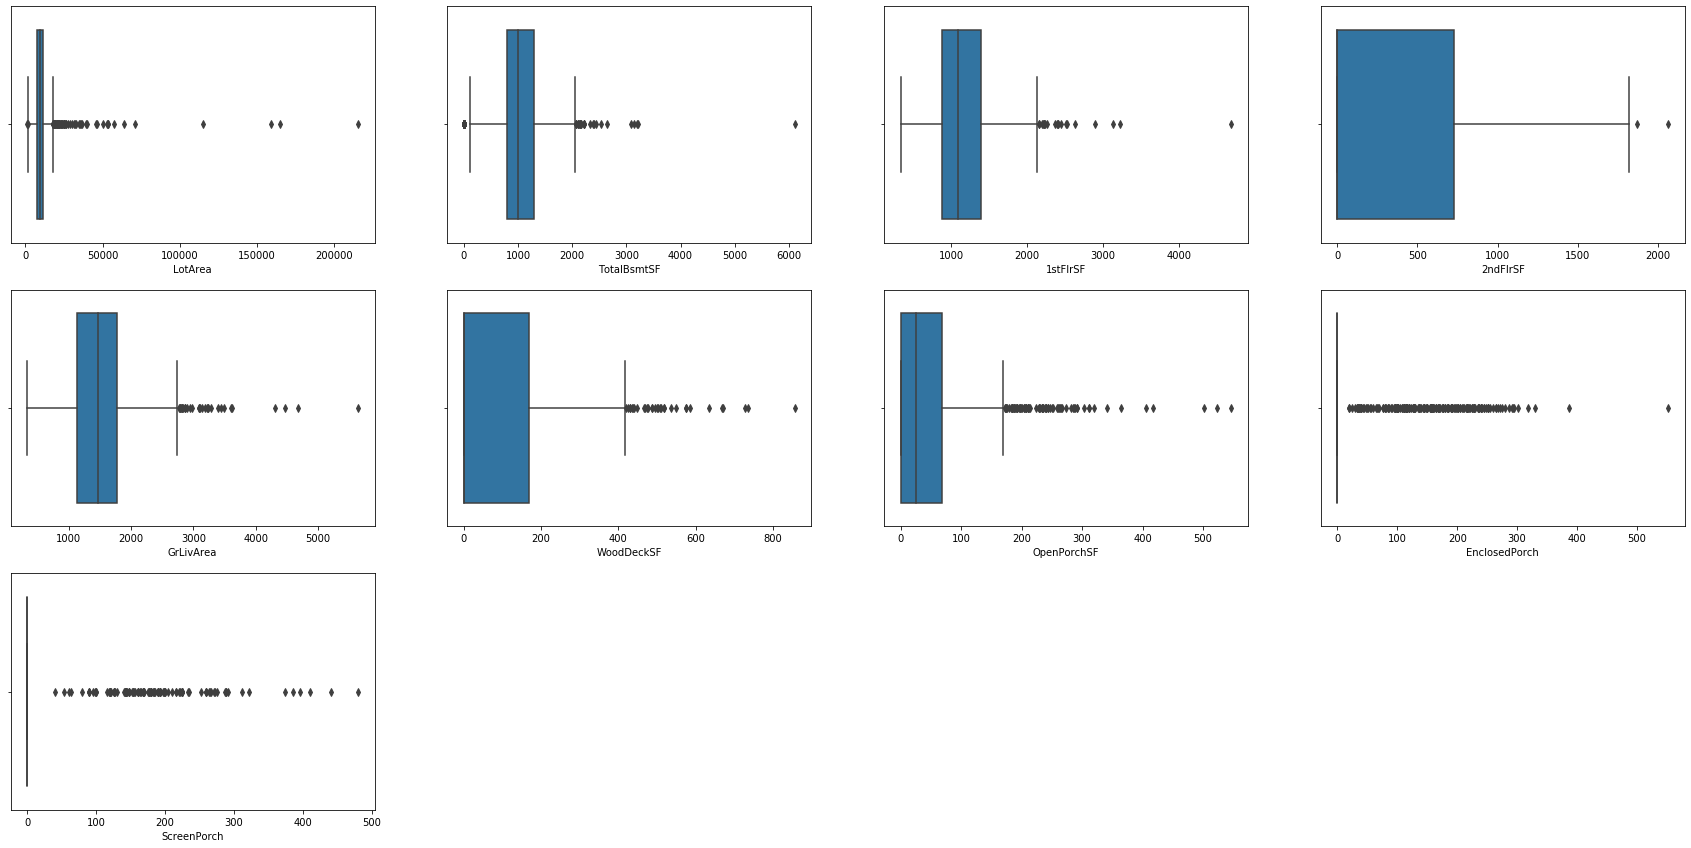

In [6]:
plt.figure(figsize=(30, 20))
columns = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']
drawBoxPlot(columns, housing_data)

### Removing Outliners

In [7]:
def outlierOnBothSides(df,columns):
    for column in columns:
        df = df[df[column] < df[column].quantile(0.98)]
        df = df[df[column] > df[column].quantile(0.02)]
    return df

def outlierOnHigherSide(df,columns):
    for column in columns:
        df = df[df[column] < df[column].quantile(0.98)]
    return df

def outlierOnLowerSide(df,columns):
    for column in columns:
        df = df[df[column] > df[column].quantile(0.0001)]
    return df

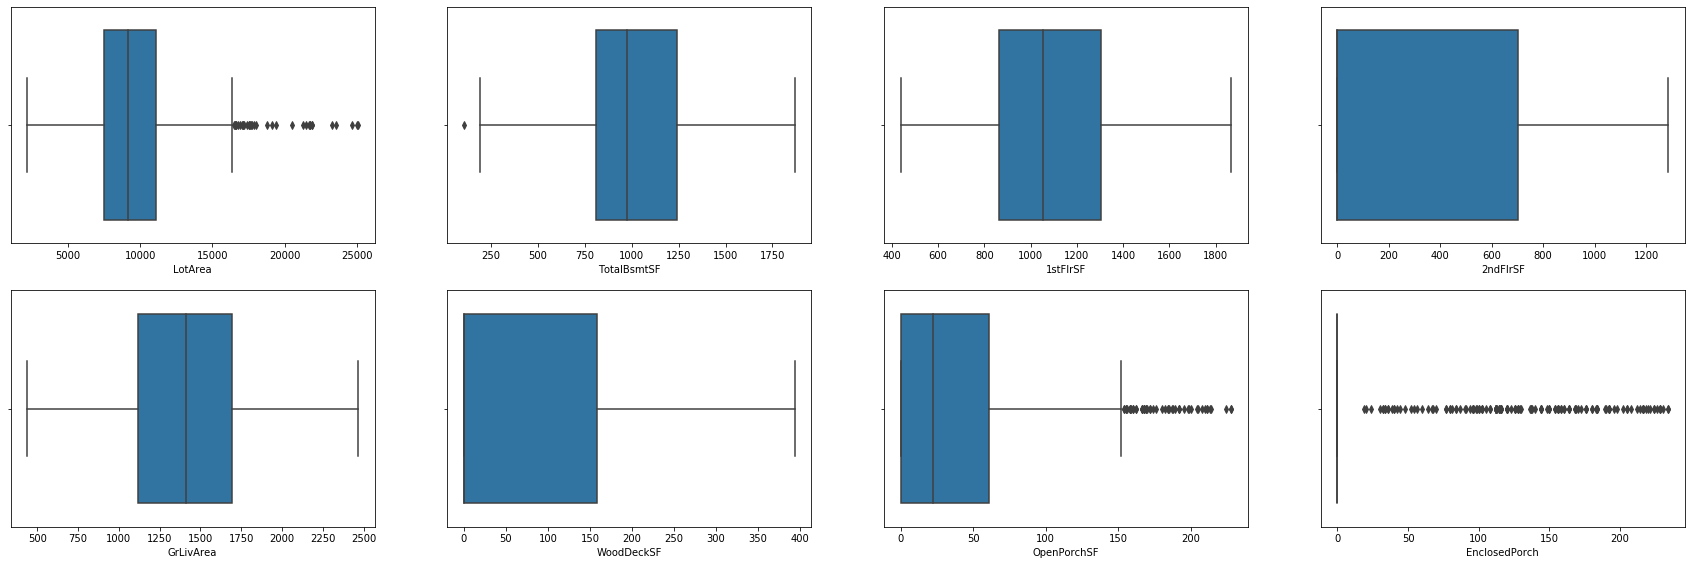

In [8]:
columnsBoth = ['LotArea', 'TotalBsmtSF']
columnsHigherSide= ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch']
columnsLowerSide = []
columns = columnsBoth + columnsHigherSide + columnsLowerSide
housing_data = outlierOnBothSides(housing_data,columnsBoth)
housing_data = outlierOnHigherSide(housing_data,columnsHigherSide)
housing_data = outlierOnLowerSide(housing_data,columnsLowerSide)

plt.figure(figsize=(30, 20))
drawBoxPlot(columns, housing_data)


### Perform Binning

In [9]:
# Perfoming Binning
year_bins = [1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020]
housing_data['YearRemodAdd'] = pd.cut(housing_data['YearRemodAdd'], year_bins)
housing_data['YearBuilt'] = pd.cut(housing_data['YearBuilt'], year_bins)
housing_data['YrSold'] = pd.cut(housing_data['YrSold'], year_bins)



In [10]:
# Continue Binning or other types
def covertToQualityTypes(val):
    if val >= 0 and val <= 2:
        return 'VERY_POOR'
    if val >= 2 and val <= 4:
        return 'POOR'
    if val >= 4 and val <= 6:
        return 'OK'
    if val >= 6 and val <= 8:
        return 'GOOD'
    if val >= 8 and val <= 10:
        return 'VERY_GOOD'
    
housing_data.OverallQual = housing_data.OverallQual.apply(lambda x: covertToQualityTypes(x))
housing_data.OverallCond = housing_data.OverallCond.apply(lambda x: covertToQualityTypes(x))

In [11]:
# Generalizing the values 

def generalizingCondition(val):
    if val == 'Artery' or val == 'Feedr':
        return 'STREET'
    if val=='RRNn' or val=='RRAn' or val == 'RRNe' or val == 'RRAe':
        return 'RAILROAD'
    if val =='PosN' or val == 'PosA':
        return 'OFFSITE-FEATURE'
    else:
        return 'NORMAL'
    
housing_data.Condition1 = housing_data.Condition1.apply(lambda x: generalizingCondition(x))
housing_data.Condition2 = housing_data.Condition2.apply(lambda x: generalizingCondition(x))


# Imputation

In [12]:
# Identifying columns which have NAN
nan_cols = [i for i in housing_data.columns if housing_data[i].isnull().any()]
def getNanColumnCount(df,columns):
    for column in columns:
        print(column, df[column].isnull().sum(axis = 0), len(df[column]))

getNanColumnCount(housing_data, nan_cols)

LotFrontage 199 1176
MasVnrType 6 1176
MasVnrArea 6 1176
BsmtExposure 1 1176
Electrical 1 1176
FireplaceQu 594 1176
GarageType 63 1176
GarageFinish 63 1176
GarageQual 63 1176
GarageCond 63 1176


In [13]:
# Missing Values imputation

def populateNAwithMedian(df,columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].median())
    return df

def populateNAwithMode(df,columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].mode()[0])
    return df

def populateNAwithNA(df,columns):
    for column in columns:
        df[column] = df[column].fillna('NA')
    return df



nan_median_cols = ['LotFrontage'] 
nan_mode_cols= ['BsmtExposure', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'MasVnrType', 'MasVnrArea']       
nan_NA_cols= ['GarageFinish'] 
housing_data = populateNAwithMedian(housing_data, nan_median_cols)
housing_data = populateNAwithMode(housing_data, nan_mode_cols)
housing_data = populateNAwithNA(housing_data, nan_NA_cols)

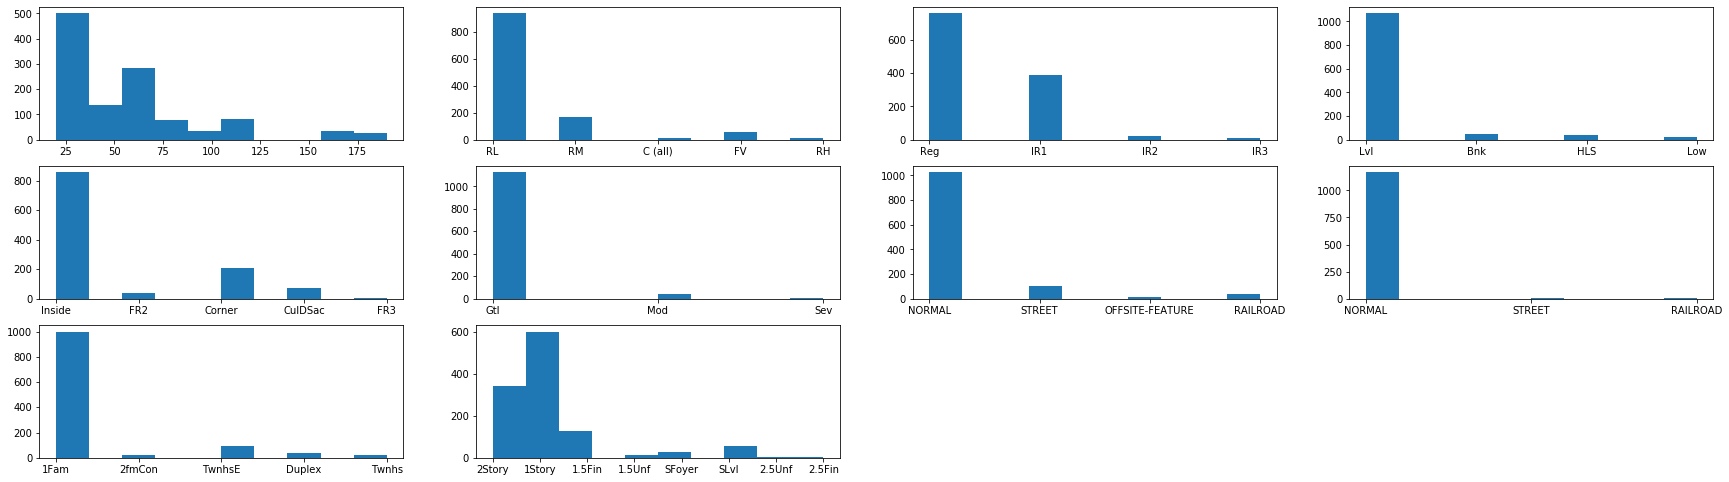

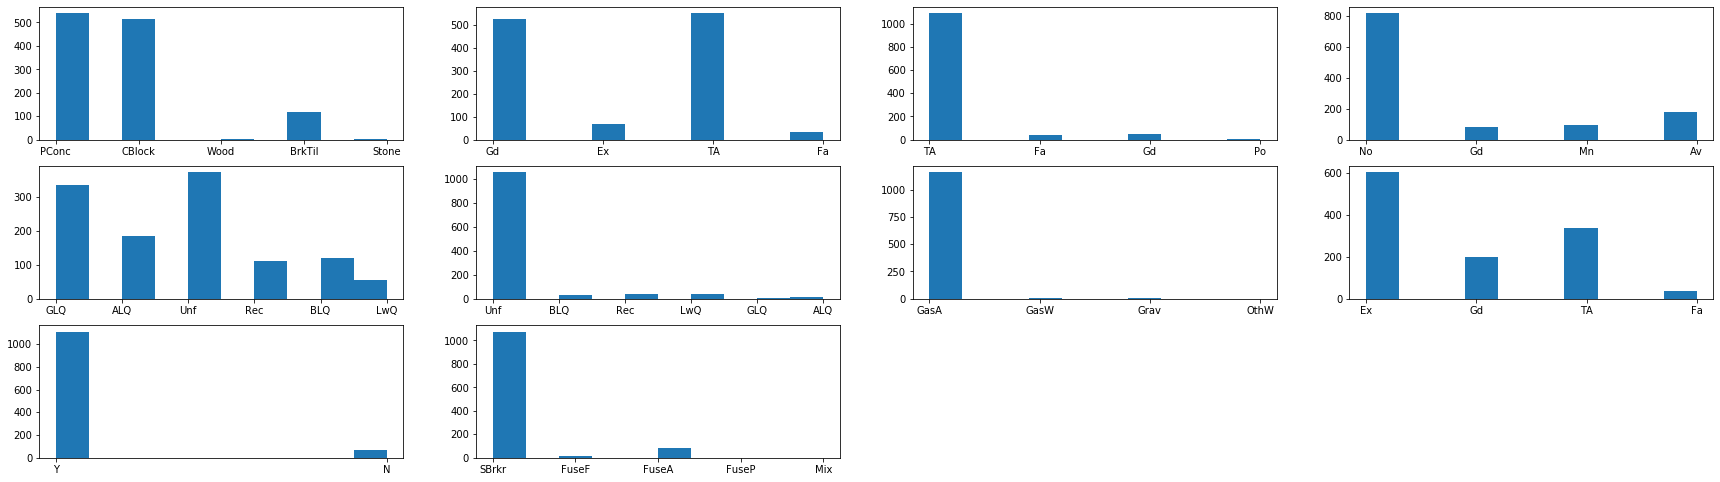

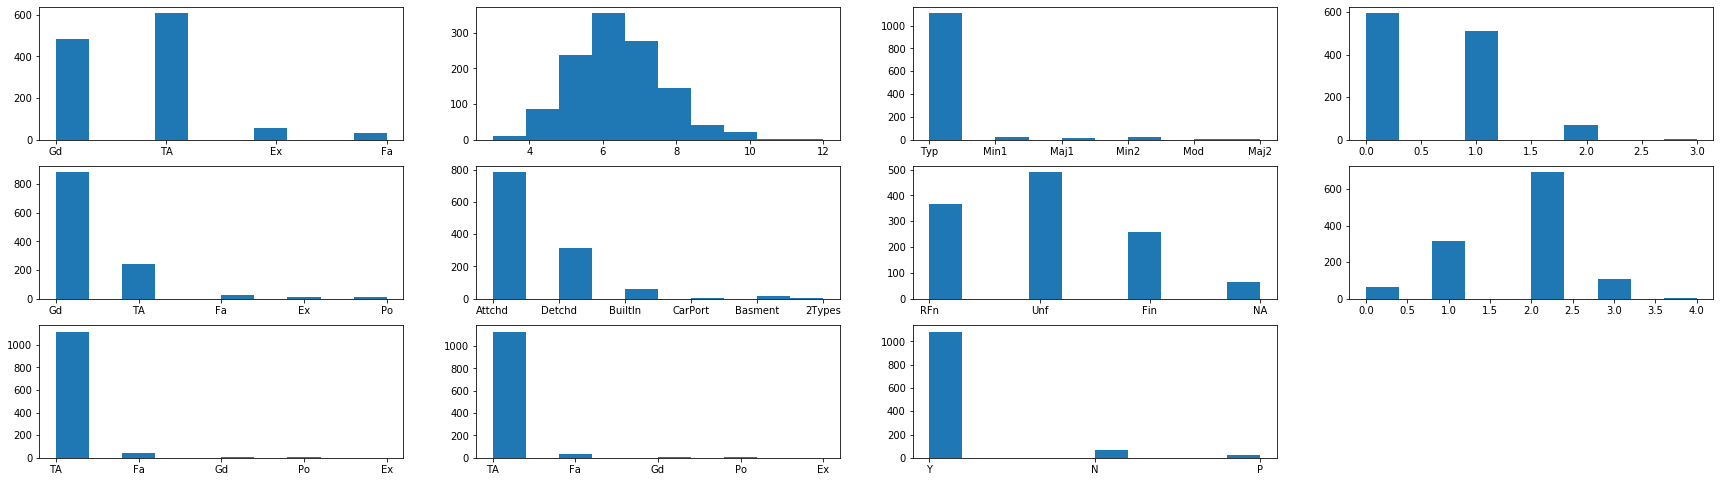

In [14]:
# Identify are remove columns which are all same

def drawHistPlot(columns,df):
    for index, item in enumerate(columns, start=1):   # default is zero
        plt.subplot(7,4,index)
        plt.hist(x = item, data = df)
        
def drawBoxPlotAginstSales(columns,df):
    for index, item in enumerate(columns, start=1):   # default is zero
        plt.subplot(4,4,index)
        sns.boxplot(x = item, y = 'SalePrice', data = df)


cat_columns = [ 'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle']
cat_columns2= ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond']
cat_columns3= ['Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical']
cat_columns4 = [ 'KitchenQual', 'TotRmsAbvGrd','Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive']
cat_columns5 = ['SaleType', 'SaleCondition', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',  'YrSold']
categoryColumns = cat_columns + cat_columns2 + cat_columns3 + cat_columns4 +cat_columns5

plt.figure(figsize=(30, 20))
drawHistPlot( cat_columns , housing_data)

plt.figure(figsize=(30, 20))
drawHistPlot( cat_columns3 , housing_data)

plt.figure(figsize=(30, 20))
drawHistPlot( cat_columns4 , housing_data)


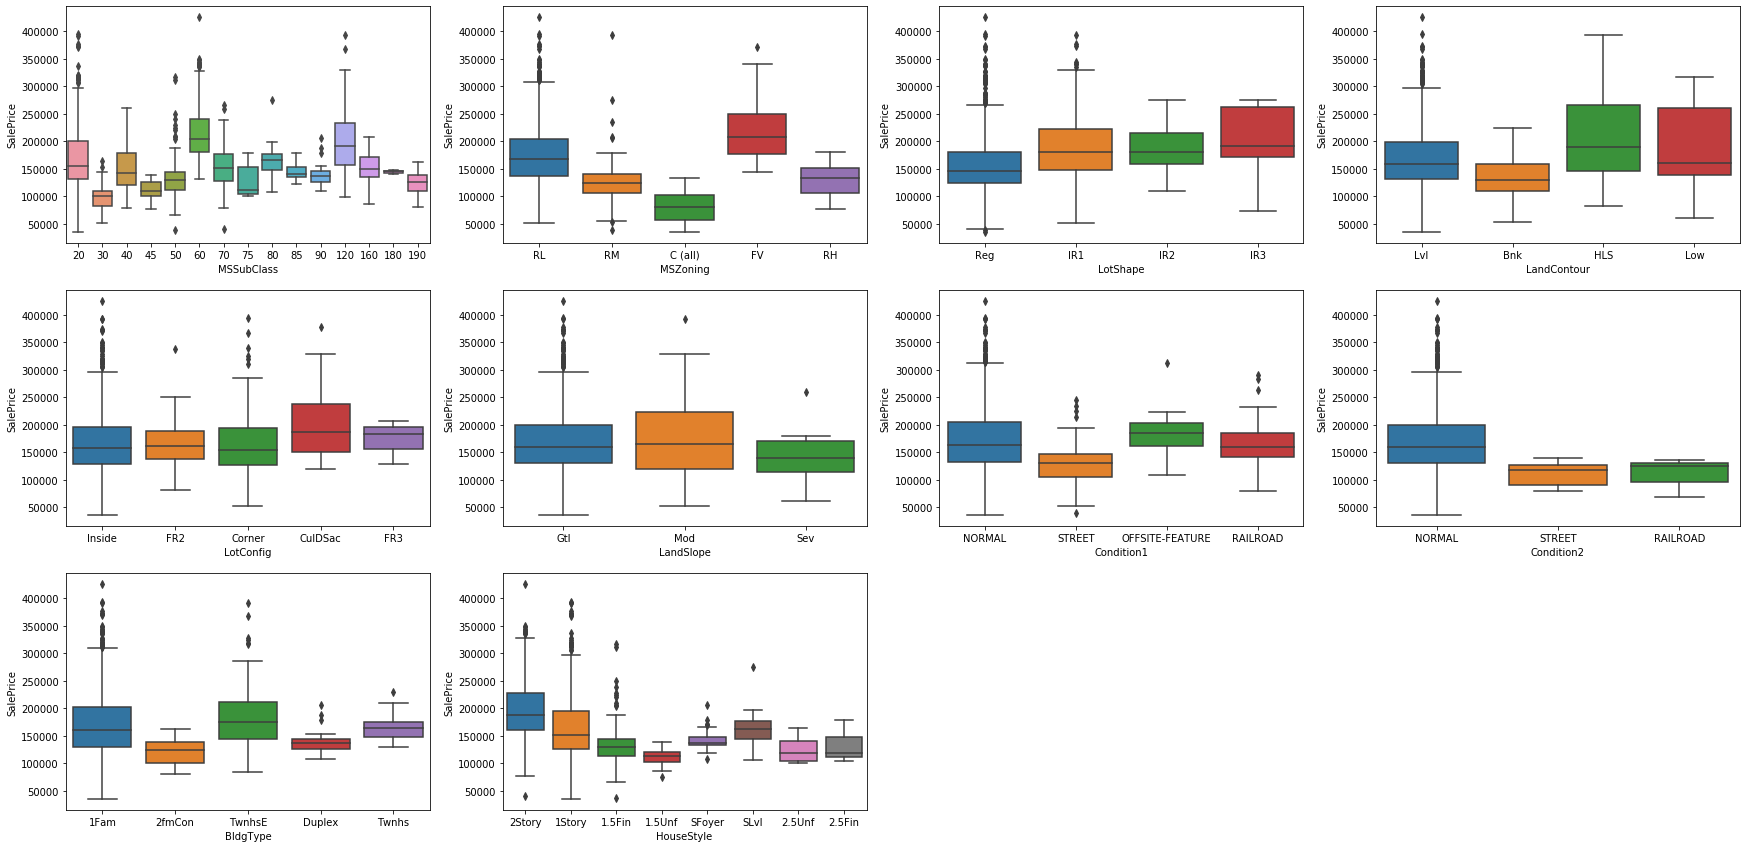

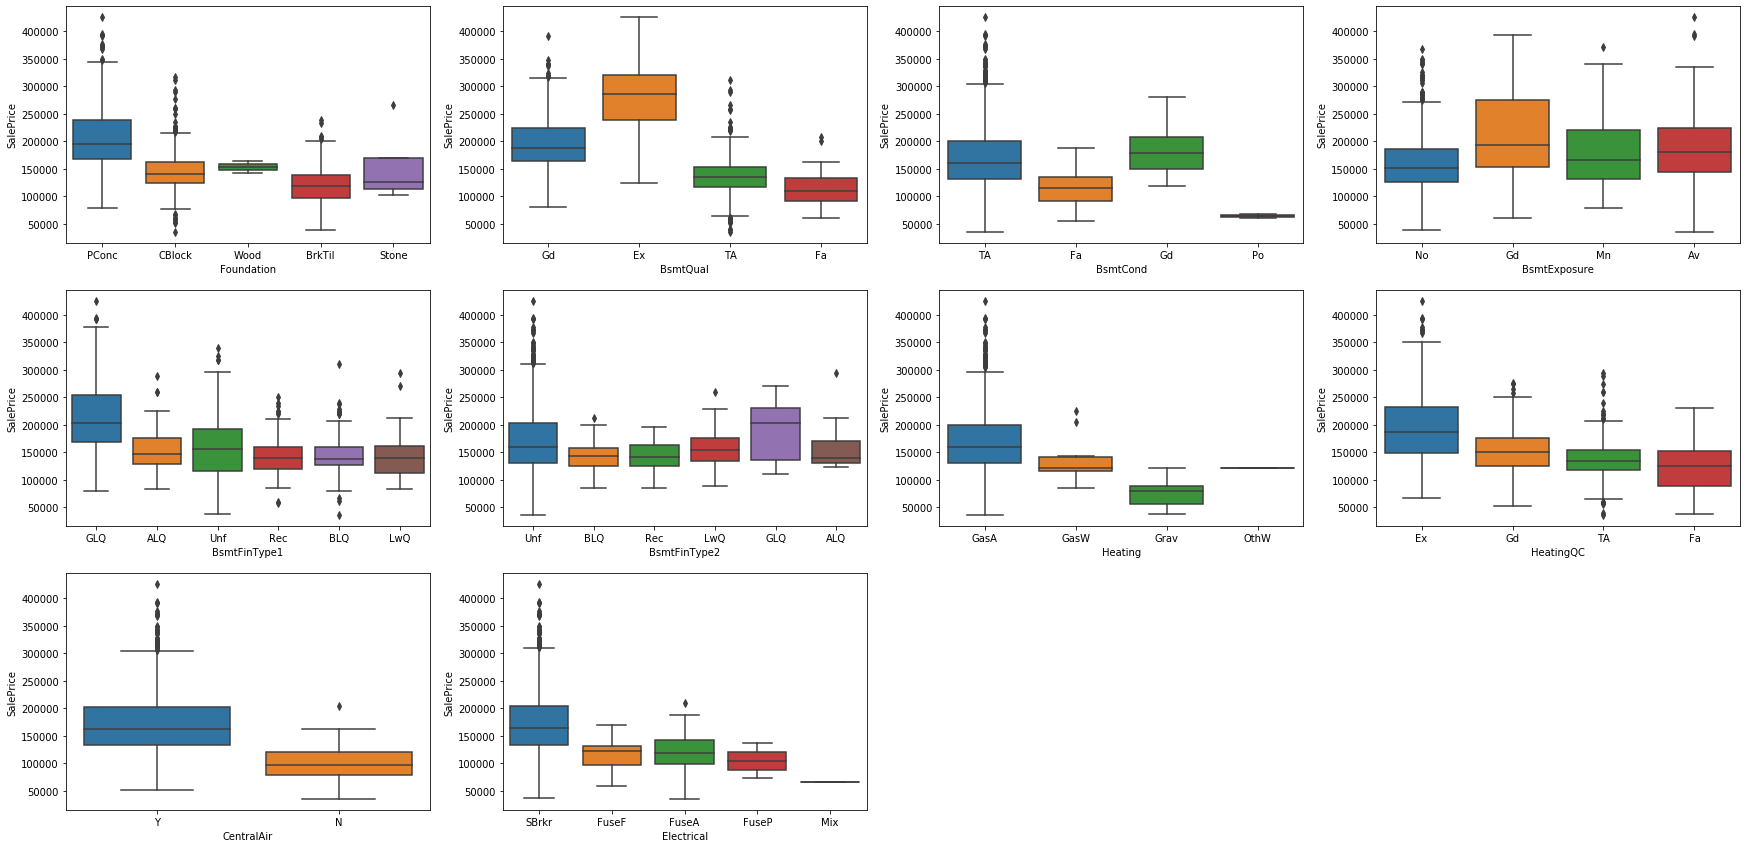

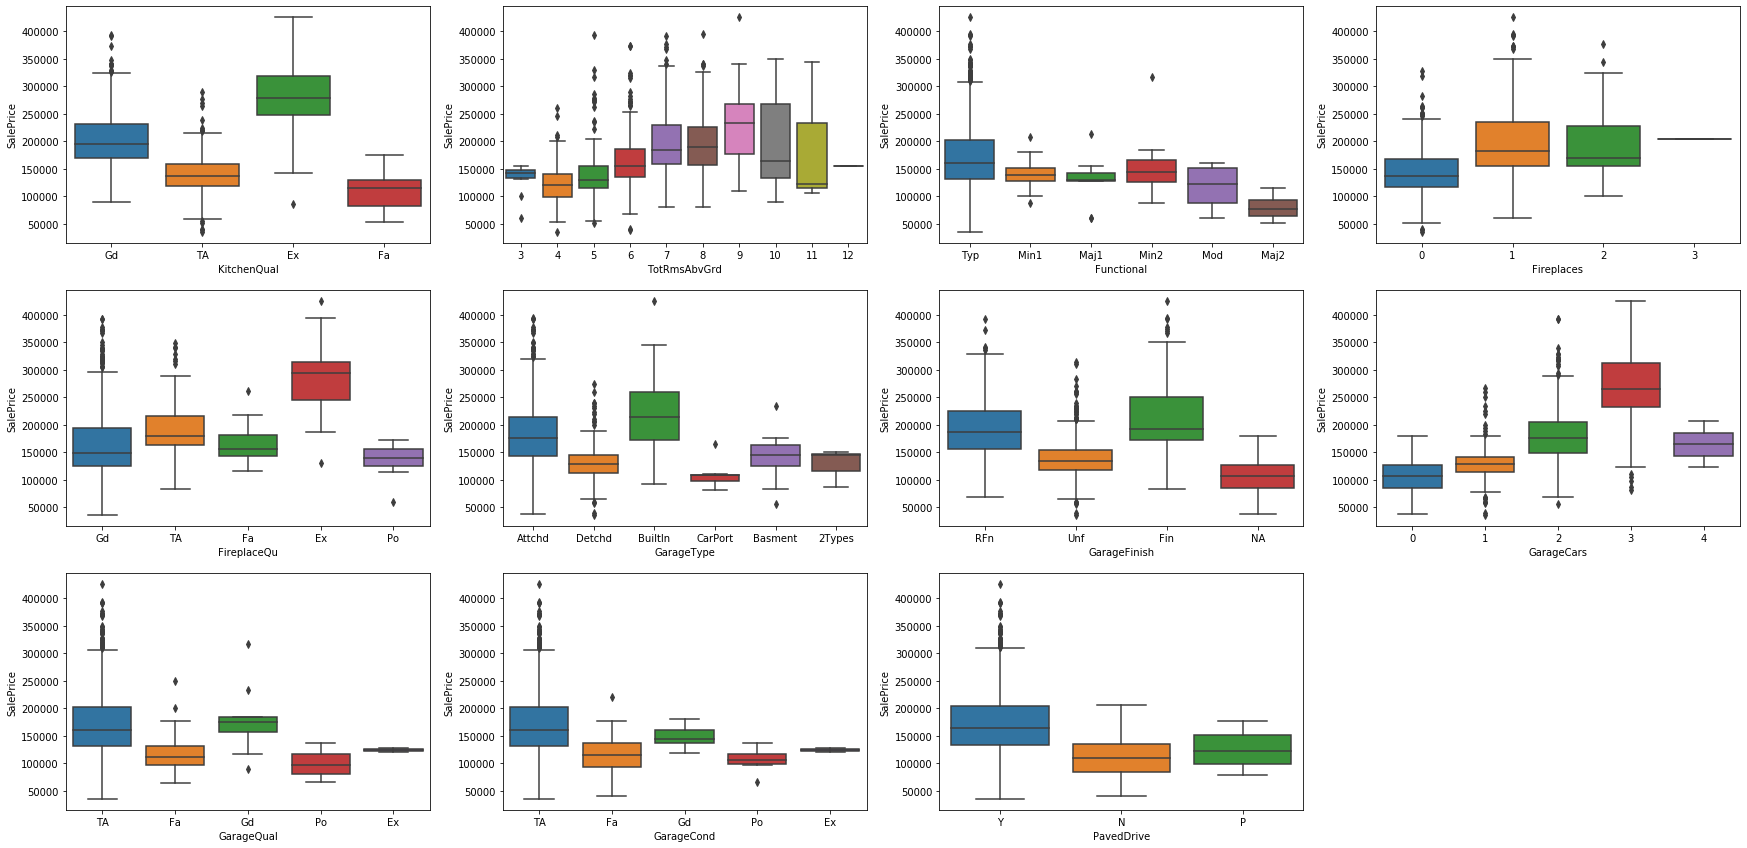

In [15]:
plt.figure(figsize=(30, 20))
drawBoxPlotAginstSales( cat_columns , housing_data)

plt.figure(figsize=(30, 20))
drawBoxPlotAginstSales( cat_columns3 , housing_data)

plt.figure(figsize=(30, 20))
drawBoxPlotAginstSales( cat_columns4 , housing_data)


## Dummy Variables Creation

In [16]:
# Creating Dummies for all categorical variables
def getDummies(dataframe, columns):
    for column in columns:
        # creating k-1 dummy variables 
        dummyVariables = pd.get_dummies(dataframe[column], prefix = column , drop_first = True)
        # adding k-1 dummy variables to the dataframe
        dataframe = pd.concat([dataframe, dummyVariables], axis = 1)
        # dropping the actual columns
        dataframe.drop([column], axis = 1, inplace = True)
    return dataframe

In [17]:
housing_data = getDummies(housing_data, categoryColumns)

## Correlation Matrix

In [18]:
# Plotting of so many variables would be non readable

#plt.figure(figsize = (50,20))        # Size of the figure
#sns.heatmap(temp.corr(),annot = True)
#plt.show()

In [19]:
# Finding correlations that have more than 75 % and drop them
corr_matrix = housing_data.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
columnsWithHighCorr = []
corrPairColumns=[]
for index, value in sol.items():
    if(value > 0.75) :
        corrPairColumns.append(index)
        columnsWithHighCorr.append(index[0])
        
housing_data = housing_data.drop(columns = columnsWithHighCorr, axis = 1)

<Figure size 2160x1440 with 0 Axes>

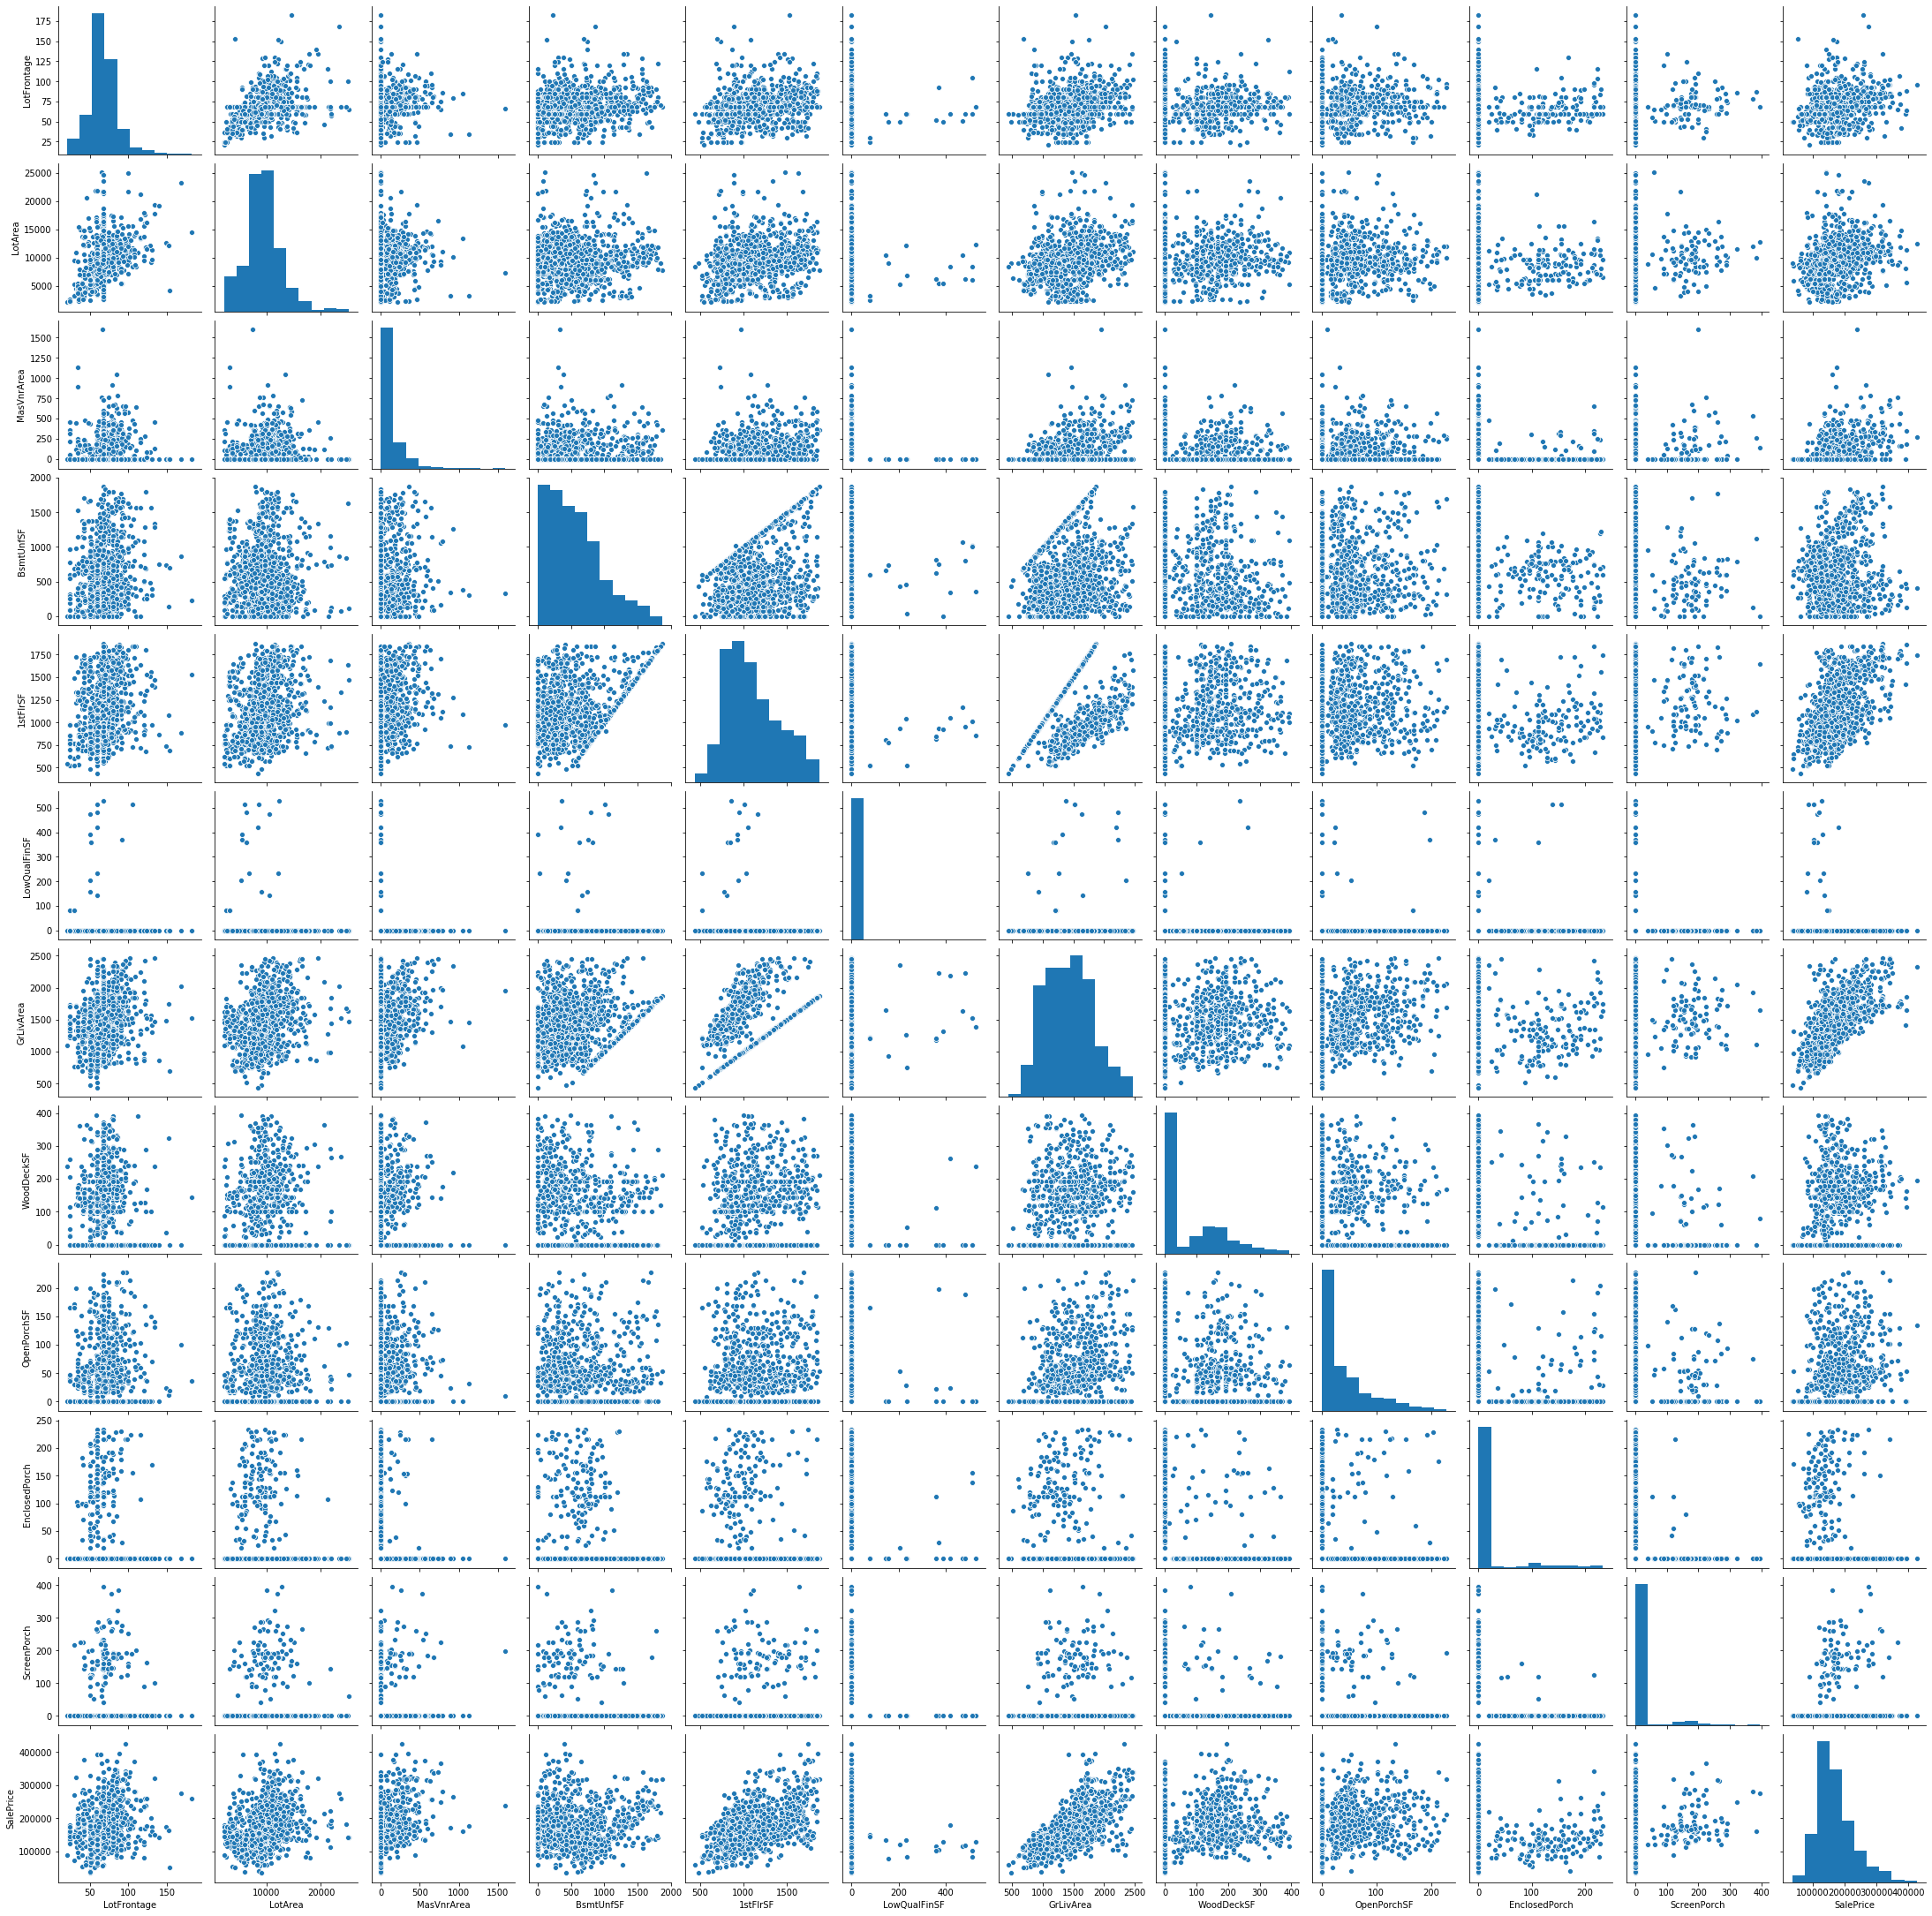

In [20]:
# Numeric Variables
numColums = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
numColums1=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice']
numeric_columns = numColums + numColums1 

num_columns = [x for x in numeric_columns if x not in columnsWithHighCorr ]

numeric_housing_data = housing_data.filter(num_columns , axis=1)

plt.figure(figsize=(30, 20))
sns.pairplot(numeric_housing_data)
plt.show()


In [30]:
# Spliting data into testing and training set
df_train, df_test = train_test_split(housing_data, train_size = 0.80, test_size = 0.20, random_state = 100)

# Scaling

In [31]:
# Apply scaler() to all other than dummy variables and 0/1 variables and only on train variables
scaler = MinMaxScaler()
housing_data[num_columns] = scaler.fit_transform(housing_data[num_columns])

# Modeling

In [32]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [33]:
# Defining to get Linear Regression Stats
def getLinearRegressionStats(X_train_columns): 
    # Add a constant
    X_train_lm = sm.add_constant(X_train_columns)
    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    return lr

# Defining to get VIF Attributes
def checkVIF(X_train_columns):
    vif = pd.DataFrame()
    vif['Features'] = X_train_columns.columns
    vif['VIF'] = [variance_inflation_factor(X_train_columns.values, i) for i in range(X_train_columns.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)


In [34]:
# Combining to get Linear Regression Stats and VIF Attributes
def getLRSummaryAndVIF(X_train, X_train_columns): 
    #X_train_columns = 
    lr_model = getLinearRegressionStats( X_train_columns)
    print(lr_model.summary())
    return lr_model

In [35]:
# Running RFE with the output number of the variable equal to 70
lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 125)             
rfe = rfe.fit(X_train, y_train)
zip(X_train.columns,rfe.support_,rfe.ranking_)

col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
lr_model = getLRSummaryAndVIF(X_train, X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     69.94
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        01:39:31   Log-Likelihood:                 1603.2
No. Observations:                 940   AIC:                            -2958.
Df Residuals:                     816   BIC:                            -2357.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [36]:
# for test data only transform the variabless
df_test[num_columns] = scaler.transform(df_test[num_columns])

In [37]:
X_test_vals = df_test[col]
X_test_constant = sm.add_constant(X_test_vals)
Predicted_cnt = lr_model.predict(X_test_constant)

In [38]:
metric = []

r_squared_train = lr_model.rsquared
metric.append(r_squared_train)

r_squared_test = r2_score(df_test.SalePrice, Predicted_cnt)
metric.append(r_squared_test)

mse_train = lr_model.mse_resid
metric.append(mse_train)

mse_test = mean_squared_error(df_test.SalePrice, Predicted_cnt)
metric.append(mse_test)


print('Mean Square error (train):', mse_train)
print('Mean Squared Error (test):' ,mse_test)
print('R square value (train):',r_squared_train)
print('R square value (test):',r_squared_test)



Mean Square error (train): 0.0022262883128966425
Mean Squared Error (test): 0.0028578515712660087
R square value (train): 0.9133576382684934
R square value (test): 0.8803298656975951


# Tuning and Regularization

In [39]:
X_lasso_ridge_train = X_train[col]
y_lasso_ridge_train = y_train

a_test = df_test.copy()
y_lasso_ridge_test = a_test.pop('SalePrice')
X_lasso_ridge_test = a_test[col]

In [40]:
def evaluateLassoRidge(X_train, y_train, X_test, y_test, model='ridge'):
    # define model
    print("============================================" + model + "============================================")
    if model == 'ridge':
        estimator_model = Ridge()
    else:
        estimator_model = Lasso()
    # define model evaluation method using k-fold
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 20, 50, 100, 300, 500, 1000 ]
    # define search
    search = GridSearchCV(estimator_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X_train, y_train)

    alpha = results.best_params_["alpha"]
    
    # summarize
    #print('Mean Absolute Error: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)


    final_model = results.best_estimator_
    final_model.fit(X_train, y_train)
    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)

    # Model Evaluation
    modelmetric =[]
    #print(model," Regression with alpha value : ",alpha)
    modelmetric.append(r2_score(y_train,y_train_pred))
    modelmetric.append(r2_score(y_test,y_test_pred))
    modelmetric.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    modelmetric.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
 
   
    return final_model, modelmetric


In [41]:
# Performing Ridge Model Evaluation
ridge_model, ridge_metric = evaluateLassoRidge(X_lasso_ridge_train, y_lasso_ridge_train,  X_lasso_ridge_test, y_lasso_ridge_test, 'ridge')

# Performing Lasso Model Evaluation
lasso_model, lasso_metric = evaluateLassoRidge(X_lasso_ridge_train, y_lasso_ridge_train,  X_lasso_ridge_test, y_lasso_ridge_test, 'lasso')

============================================ridge============================================
Config: {'alpha': 0.5}
============================================lasso============================================
Config: {'alpha': 0.005}


In [42]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)', 'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
rg_metric = pd.Series(ridge_metric, name = 'Ridge Regression')
ls_metric = pd.Series(lasso_metric, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.913358,0.911640,0.731482
1,R2 Score (Test),0.880330,0.894562,0.779642
2,MSE (Train),0.002226,0.044395,0.077391
3,MSE (Test),0.002858,0.050179,0.072542


In [43]:
# Looking at co-efficients of different Models
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.Series(ridge_model.coef_, index = col).sort_values(ascending=False)
pd.Series(lasso_model.coef_, index = col).sort_values(ascending=False)

coefficients = pd.DataFrame(index=col)
coefficients.rows = col
coefficients['Linear Regression'] = lr_model.params
coefficients['Ridge'] = ridge_model.coef_
coefficients['Lasso'] = lasso_model.coef_
coefficients.head(20)

,Linear Regression,Ridge,Lasso
LotFrontage,0.038708,0.034890,0.000000
LotArea,0.047047,0.050640,0.000000
MasVnrArea,0.077734,0.075453,0.000000
BsmtUnfSF,-0.055670,-0.055612,-0.000000
1stFlrSF,0.104291,0.104851,0.053344
LowQualFinSF,-0.022021,-0.023441,-0.000000
GrLivArea,0.318984,0.289849,0.169634
WoodDeckSF,0.019205,0.018723,0.000000
OpenPorchSF,0.016439,0.017354,0.000000
ScreenPorch,0.037417,0.034734,0.000000


In [44]:
pd.Series(ridge_model.coef_, index = col).sort_values(ascending=False)

GrLivArea                 0.289849
OverallQual_VERY_GOOD     0.132392
1stFlrSF                  0.104851
MasVnrArea                0.075453
SaleCondition_AdjLand     0.073824
                            ...   
OverallQual_VERY_POOR    -0.071594
YearBuilt_(1880, 1900]   -0.072835
LandSlope_Sev            -0.075631
RoofMatl_Tar&Grv         -0.094205
Foundation_Wood          -0.105843
Length: 125, dtype: float64

## Evaluate Model

In [45]:
def evaluateModel(model, modelName): 
    prediction = model.predict(X_lasso_ridge_test)
    # Plotting y_test and y_pred to understand the spread for ridge regression.
    fig = plt.figure(dpi=100)
    plt.scatter(y_lasso_ridge_test, prediction)
    fig.suptitle('y_test vs ' +  modelName, fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('Prediction', fontsize=16)  
    plt.show()

    fig = plt.figure(dpi=100)
    y_res=y_lasso_ridge_test-prediction
    # Distribution of errors
    sns.distplot(y_res,kde=True)
    plt.title('Normality of error terms/residuals')
    plt.xlabel("Residuals")
    plt.show()

 ========== EVALUATION ON ERROR DISTRIBUTION FOR RIDGE MODEL ===================


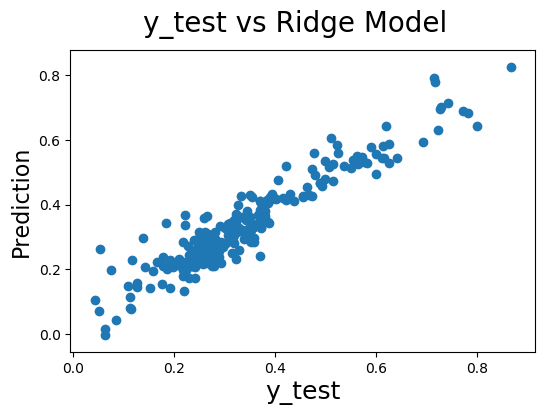

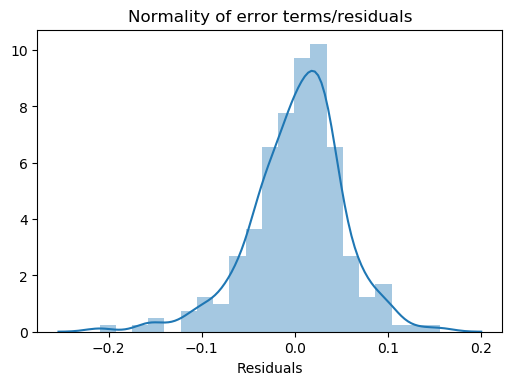

 ========== EVALUATION ON ERROR DISTRIBUTION FOR LASSO MODEL ===================


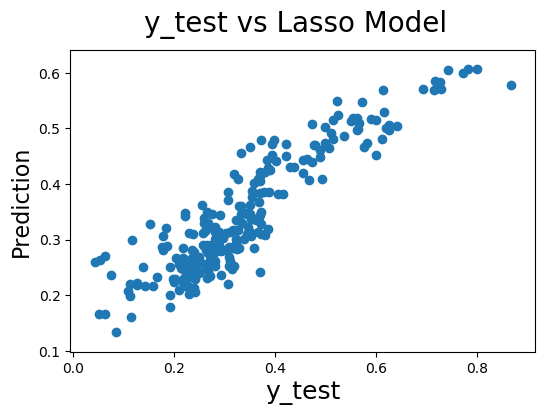

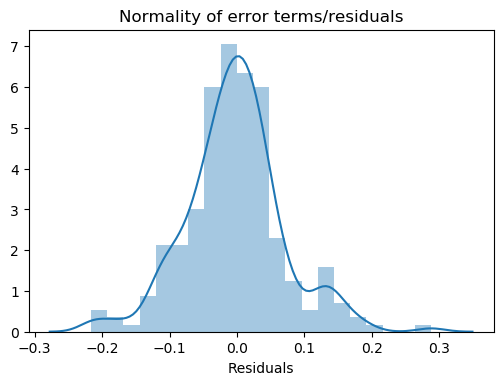

In [46]:
print(" ========== EVALUATION ON ERROR DISTRIBUTION FOR RIDGE MODEL ===================")
evaluateModel(ridge_model, "Ridge Model")

print(" ========== EVALUATION ON ERROR DISTRIBUTION FOR LASSO MODEL ===================")
evaluateModel(lasso_model, "Lasso Model")

Q1-Which variables are significant in predicting the price of a house?

GrLivArea -- Above grade (ground) living area square feet, Higher the area the better is the significance

OverallQual_VERY_GOOD --Rates the overall material and finish of the house should be 9 or 10 for better significance

1stFlrSF -- First Floor square feet should be higher for better significance

Foundation_Wood - Type of foundation is wood is having negative corelation

RoofMatl_Tar -- Roof material of type Gravel & Tar is having negative correlation

Q2 -- How well those variables describe the price of a house.

R2 score for ridge for train is around 91% and test is around 89 %. So we should be able to explain these price of the home to approximately 90%



## Finding answers for questionaire

In [47]:
pd.Series(ridge_model.coef_, index = col).abs().sort_values(ascending=False).head(5)

GrLivArea                0.289849
OverallQual_VERY_GOOD    0.132392
Foundation_Wood          0.105843
1stFlrSF                 0.104851
RoofMatl_Tar&Grv         0.094205
dtype: float64

In [48]:
pd.Series(lasso_model.coef_, index = col).abs().sort_values(ascending=False).head(5)

GrLivArea           0.169634
1stFlrSF            0.053344
ExterQual_TA        0.051320
GarageCars_3        0.049846
BsmtFinType1_GLQ    0.032867
dtype: float64

In [49]:
def evaluateLassoRidgeForAlphaValue(X_train, y_train, X_test, y_test, model='ridge'):
    # define model
    print("============================================" + model + "============================================")
    if model == 'ridge':
        estimator_model = Ridge()
    else:
        estimator_model = Lasso()
    # define model evaluation method using k-fold
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = [0.01]
    # define search
    search = GridSearchCV(estimator_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X_train, y_train)

    alpha = results.best_params_["alpha"]
    
    # summarize
    print('Mean Absolute Error: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)


    final_model = results.best_estimator_
    final_model.fit(X_train, y_train)
    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)

    # Model Evaluation
    print(model," Regression with alpha value : ",alpha)
    print('R2 score (train) : ',r2_score(y_train,y_train_pred))
    print('R2 score (test) : ',r2_score(y_test,y_test_pred))
    print('RMSE (train) : ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('RMSE (test) : ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

    return final_model


In [50]:
# Performing Ridge Model Evaluation
#ridge_model = evaluateLassoRidgeForAlphaValue(X_lasso_ridge_train, y_lasso_ridge_train,  X_lasso_ridge_test, y_lasso_ridge_test , 'ridge')

# Performing Lasso Model Evaluation
lasso_model = evaluateLassoRidgeForAlphaValue(X_lasso_ridge_train, y_lasso_ridge_train,  X_lasso_ridge_test, y_lasso_ridge_test, 'lasso')

============================================lasso============================================
Mean Absolute Error: -0.071
Config: {'alpha': 0.01}
lasso  Regression with alpha value :  0.01
R2 score (train) :  0.5746629509803098
R2 score (test) :  0.6175060803041317
RMSE (train) :  0.09740322166304904
RMSE (test) :  0.09557387908205196


In [51]:
pd.Series(ridge_model.coef_, index = col).abs().sort_values(ascending=False).head(5)

GrLivArea                0.289849
OverallQual_VERY_GOOD    0.132392
Foundation_Wood          0.105843
1stFlrSF                 0.104851
RoofMatl_Tar&Grv         0.094205
dtype: float64

In [52]:
pd.Series(lasso_model.coef_, index = col).sort_values(ascending=False).head(5)

GrLivArea           0.071130
Fireplaces_1        0.032607
BsmtFinType1_GLQ    0.029415
GarageCars_3        0.023184
Foundation_PConc    0.021996
dtype: float64

# Q3 

In [53]:
dropColumns_q3  = ['GrLivArea', 'Fireplaces_1', 'BsmtFinType1_GLQ', 'GarageCars_3', 'Foundation_PConc']
X_lasso_ridge_train = X_lasso_ridge_train.drop(columns = dropColumns_q3, axis = 1)
X_lasso_ridge_test = X_lasso_ridge_test.drop(columns = dropColumns_q3, axis = 1)

In [54]:
# Performing Lasso Model Evaluation
lasso_model_q3, lasso_metric_q3 = evaluateLassoRidge(X_lasso_ridge_train, y_lasso_ridge_train,  X_lasso_ridge_test, y_lasso_ridge_test, 'lasso')

============================================lasso============================================
Config: {'alpha': 0.005}


In [55]:
pd.Series(lasso_model_q3.coef_, index = X_lasso_ridge_train.columns).sort_values(ascending=False).head(5)

1stFlrSF            0.112649
BsmtFullBath_1      0.015411
MasVnrType_Stone    0.011772
TotRmsAbvGrd_7      0.008284
TotRmsAbvGrd_8      0.007613
dtype: float64

In [56]:
lr_table1 = {'Metric': ['R2 Score (Train)','R2 Score (Test)', 'MSE (Train)','MSE (Test)'], 
        'Lasso Regression': lasso_metric_q3
        }

lr_metric1 = pd.DataFrame(lr_table1 ,columns = ['Metric', 'Lasso Regression'] )

lr_metric1

,Metric,Lasso Regression
0,R2 Score (Train),0.625679
1,R2 Score (Test),0.662340
2,MSE (Train),0.091375
3,MSE (Test),0.089798


In [57]:
exit()